(-0.5, 1439.5, 2559.5, -0.5)

<Figure size 720x720 with 0 Axes>

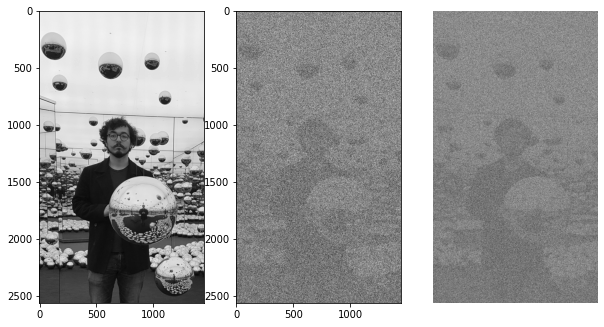

In [90]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.rcParams['figure.figsize'] = [10, 10]

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def salt(im,percent):
    image = im.copy()
    siz =im.shape[0]*im.shape[1]
    xys = random.sample(range(siz), int(siz*percent))
    coords = [divmod(xy, im.shape[1]) for xy in xys]
    # apply noise to coordinates
    for c in coords:
        image[c]=np.random.randint(2)
    return image,coords

def rvin(im,percent):
    image = im.copy()
    siz =im.shape[0]*im.shape[1]
    xys = random.sample(range(siz), int(siz*percent))
    coords = [divmod(xy, im.shape[1]) for xy in xys]
    # apply noise to coordinates
    for c in coords:
        image[c]=np.random.uniform(0, 1)
    return image,coords

im = rgb2gray(imread("yo.jpg")/255)
percent = .9
sa,csalt = salt(im,percent)
rv,crvin = rvin(im,percent)

plt.figure()
f, axarr = plt.subplots(1,3) 
axarr[0].imshow(im, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
axarr[1].imshow(sa, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
axarr[2].imshow(rv, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

43.56960937747213

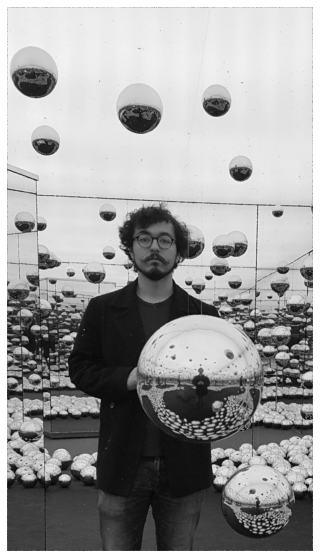

In [2]:
def median(im,coords):
    sa = im.copy()
    for c in coords:
        if (c[0] > 1) & (c[1] > 1) & (c[0] < sa.shape[0]-2) & (c[1] < sa.shape[1]-2):
            sa[c] = np.median((
                            sa[c[0]-2][c[1]+2], sa[c[0]][c[1]+2], sa[c[0]+2][c[1]+2], 
                            sa[c[0]-2][c[1]], sa[c[0]+2][c[1]], 
                            sa[c[0]-2][c[1]-2], sa[c[0]][c[1]-2], sa[c[0]+2][c[1]-2],
                
                            sa[c[0]-1][c[1]+2], sa[c[0]+1][c[1]+2], sa[c[0]+2][c[1]+1], 
                            sa[c[0]-2][c[1]+1], sa[c[0]+2][c[1]+1], 
                            sa[c[0]-1][c[1]-2], sa[c[0]+1][c[1]-2], sa[c[0]+2][c[1]-1],
                            
                            sa[c[0]-1][c[1]+1], sa[c[0]][c[1]+1], sa[c[0]+1][c[1]+1], 
                            sa[c[0]-1][c[1]], sa[c[0]][c[1]], sa[c[0]+1][c[1]], 
                            sa[c[0]-1][c[1]-1], sa[c[0]][c[1]-1], sa[c[0]+1][c[1]-1], 
                            ))
    return sa

out = median(sa, csalt)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
mse = (abs(out*255 - im*255)).mean(axis=None)
psnr = 10*np.log10((255*255)/mse)
psnr

41.74570737940276

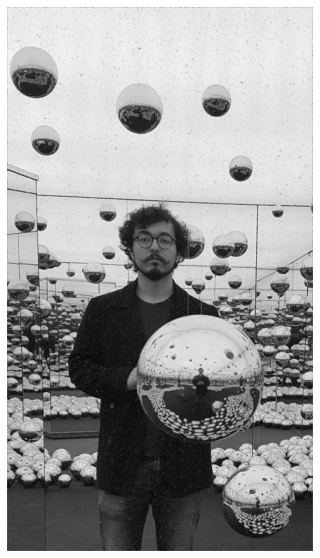

In [3]:
out = median(rv, crvin)
plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
mse = (abs(out*255 - im*255)).mean(axis=None)
psnr = 10*np.log10((255*255)/mse)
psnr

In [103]:
labels = np.zeros(sa.shape)
for c in csalt:
        labels[c]=1
x = []
y = []
for i in range(sa.shape[0]):
    for j in range(sa.shape[1]):
        if (i > 0) & (j > 0) & (i < sa.shape[0]-1) & (j < sa.shape[1]-1):
            x.append((sa[i-1][j+1], sa[i][j+1], sa[i+1][j+1], 
                    sa[i-1][j], sa[i][j], sa[i+1][j], 
                    sa[i-1][j-1], sa[i][j-1], sa[i+1][j-1]))
            y.append(labels[i][j])
x = np.array(x)
y = np.array(y)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, Dropout, 
                          MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Define arquitecture
model = Sequential()
model.add(Dense(32, input_dim=9, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam',loss="mse", metrics=["mse"])

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

# checkpointer = ModelCheckpoint(filepath="fashion_mnist_model.h5",
#                                verbose=1, save_best_only=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=3,
          validation_split=0.2,
          callbacks = [reduce_lr],
          #callbacks = [reduce_lr,checkpointer],
          verbose=1)

Epoch 1/3
9197/9197 [==============================] - 11s 1ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/3
9197/9197 [==============================] - 11s 1ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 3/3
9197/9197 [==============================] - 10s 1ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0036 - val_mse: 0.0036


In [102]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

def accuracy(y_true, y_pred):
    if not (len(y_true) == len(y_pred)):
        print('Size of predicted and true labels not equal.')
        return 0.0

    corr = 0
    for i in range(0,len(y_true)):
        corr += 1 if (y_true[i] == y_pred[i]).all() else 0

    return corr/len(y_true)

scores = model.predict(x_test, verbose=1, batch_size=100)
y2 = [decode_sentiment(score) for score in scores]

calc = accuracy(y_test, y2)
calc

7357/7357 [==============================] - 6s 786us/step


2.7185695974206212e-05

In [94]:
im = rgb2gray(imread("yo.jpg")/255)
def extractxy(clean,noisy):
    x = []
    y = []
    im = noisy.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (i > 0) & (j > 0) & (i < im.shape[0]-1) & (j < im.shape[1]-1):
                x.append((im[i-1][j+1], im[i][j+1], im[i+1][j+1], 
                        im[i-1][j], im[i+1][j], 
                        im[i-1][j-1], im[i][j-1], im[i+1][j-1]))
                y.append(clean[i][j])
    x = np.array(x)
    y = np.array(y)
    return x,y
x,y = extractxy(im,sa)

In [95]:
x = np.reshape(x, (x.shape[0],8,1))
y = y.reshape(-1,1)

In [83]:
from tensorflow.keras.layers import (Dense, Bidirectional, LSTM, Concatenate, 
                                     Dropout, Embedding, GRU, SimpleRNN,
                                     Input, Attention, GlobalMaxPool1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Define arquitecture
# model = Sequential()
# model.add(SimpleRNN(32,return_sequences=True, activation='relu',input_shape=(8,1)))
# model.add(SimpleRNN(16))
# model.add(Dense(1))

input_size = 8
inputs = Input(shape=(input_size))
decoder = Dense(8, input_dim=8, activation="relu")(inputs)
att = Attention(8)([inputs, decoder])
att = Flatten()(att)
predictions = Dense(1, activation='sigmoid')(att)


model.compile(optimizer='adam',loss="mse", metrics=["mse"])

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

# checkpointer = ModelCheckpoint(filepath="fashion_mnist_model.h5",
#                                verbose=1, save_best_only=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=3,
          validation_split=0.2,
          callbacks = [reduce_lr],
          #callbacks = [reduce_lr,checkpointer],
          verbose=1)

Epoch 1/3
9197/9197 [==============================] - 30s 3ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/3
9197/9197 [==============================] - 30s 3ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/3
9197/9197 [==============================] - 30s 3ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0011 - val_mse: 0.0011


In [96]:
ypred = model.predict(x, verbose=1, batch_size=100)

36785/36785 [==============================] - 30s 805us/step


In [97]:
B = np.reshape(ypred, (im.shape[0]-2,im.shape[1]-2))

In [99]:
def switchrnn(im,coords,rnnn):
    rnnout = im.copy()
    for c in coords:
        if (c[0] > 0) & (c[1] > 0) & (c[0] < rnnout.shape[0]-1) & (c[1] < rnnout.shape[1]-1):
            rnnout[c] = rnnn[c[0]-1,c[1]-1]
    return rnnout
end = switchrnn(sa,csalt,B)
mse = (abs(end*255 - im*255)).mean(axis=None)
psnr = 10*np.log10((255*255)/mse)
psnr

32.78840608720501

(-0.5, 1439.5, 2559.5, -0.5)

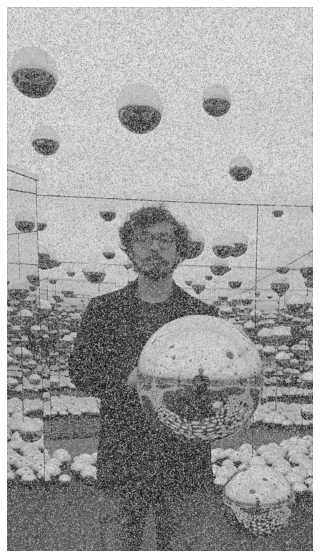

In [100]:
plt.imshow(end, cmap='gray', vmin=0, vmax=1)
plt.axis('off')